# Document Parsing

In this notebook, we will be iterating through all the links created in file 2.2. (i.e. link_dict.pickle), extracting the necessary information, and then saving an updated dictionary, which will be analyzed in section 3. 

In [64]:
import numpy as np
import pandas as pd
import os
import pickle
import time
import json
import requests
import re

from bs4 import BeautifulSoup

In [4]:
with open('../Step1-Data/2-link_dict.pickle', 'rb') as f:
    link_dict = pickle.load(f)

In [1]:
# Sanity check
list(link_dict.keys())[:5]

NameError: name 'link_dict' is not defined

In [2]:
import pdfkit
pdfkit.from_url('https://www.sec.gov/Archives/edgar/data/835910/000083591001000012/0000835910-01-000012.txt', 'aaaaa.pdf')

Loading pages (1/6)
Counting pages (2/6)                                               
Resolving links (4/6)                                                       
Loading headers and footers (5/6)                                           
Printing pages (6/6)
Done                                                                        


True

# Single Name Sample

First, we will start by using a single name to parse its documents, then extrapolate to all.

In [12]:
sample = link_dict['0000006201']
sample

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,Link
49,0000006201-21-000014,2021-02-17,2020-12-31,2021-02-17T17:17:57.000Z,34,10-K,001-08400,21646186,,43925703,1,1,aal-20201231.htm,10-K 2020 02.17.21,https://www.sec.gov/Archives/edgar/data/6201/0...
150,0000006201-20-000023,2020-02-19,2019-12-31,2020-02-19T07:31:30.000Z,34,10-K,001-08400,20627428,,30851334,1,1,a10k123119.htm,10-K 2019 02.19.20,https://www.sec.gov/Archives/edgar/data/6201/0...
225,0000006201-19-000009,2019-02-25,2018-12-31,2019-02-25T07:31:34.000Z,34,10-K,001-08400,19628071,,30572408,1,0,a10k123118.htm,10-K 2018 02.25.19,https://www.sec.gov/Archives/edgar/data/6201/0...
315,0000006201-18-000009,2018-02-21,2017-12-31,2018-02-21T08:02:40.000Z,34,10-K,001-08400,18627088,,27914491,1,0,a10k123117.htm,10-K,https://www.sec.gov/Archives/edgar/data/6201/0...
412,0001193125-17-051216,2017-02-22,2016-12-31,2017-02-22T08:01:43.000Z,34,10-K,001-08400,17627073,,24888480,1,0,d286458d10k.htm,FORM 10-K,https://www.sec.gov/Archives/edgar/data/6201/0...
538,0001193125-16-474605,2016-02-24,2015-12-31,2016-02-24T08:04:10.000Z,34,10-K,001-08400,161450518,,26170400,1,0,d78287d10k.htm,FORM 10-K,https://www.sec.gov/Archives/edgar/data/6201/0...
651,0001193125-15-061145,2015-02-25,2014-12-31,2015-02-25T08:02:34.000Z,34,10-K,001-08400,15645918,,39524925,1,0,d829913d10k.htm,FORM 10-K,https://www.sec.gov/Archives/edgar/data/6201/0...
750,0000006201-14-000004,2014-02-28,2013-12-31,2014-02-28T07:52:16.000Z,34,10-K,001-08400,14651496,,47888955,1,0,aagaa10k-20131231.htm,10-K,https://www.sec.gov/Archives/edgar/data/6201/0...


In [271]:
sample_link = sample['Link'].values[0]
sample_link

'https://www.sec.gov/Archives/edgar/data/1555280/000155528021000098/zts-20201231.htm'

In [279]:
sample[sample['reportDate'].values > '1996-01-01']

,accessionNumber,filingDate,reportDate,acceptanceDateTime,act,form,fileNumber,filmNumber,items,size,isXBRL,isInlineXBRL,primaryDocument,primaryDocDescription,Link,Loc7,Loc8
90,0001555280-21-000098,2021-02-16,2020-12-31,2021-02-16T14:24:47.000Z,34,10-K,001-35797,21636290,,18961290,1,1,zts-20201231.htm,10-K,https://www.sec.gov/Archives/edgar/data/155528...,<callable_iterator object at 0x7fc269c1bcd0>,<callable_iterator object at 0x7fc27d64d350>
277,0001555280-20-000054,2020-02-13,2019-12-31,2020-02-13T15:13:44.000Z,34,10-K,001-35797,20609808,,21406402,1,1,zoetis-20191231x10kye.htm,10-K,https://www.sec.gov/Archives/edgar/data/155528...,<callable_iterator object at 0x7fc34926f410>,<callable_iterator object at 0x7fc269c25590>
428,0001555280-19-000041,2019-02-14,2018-12-31,2019-02-14T17:08:33.000Z,34,10-K,001-35797,19608112,,19494677,1,0,zoetis-20181231x10kye.htm,10-K,https://www.sec.gov/Archives/edgar/data/155528...,<callable_iterator object at 0x7fc346aaa450>,<callable_iterator object at 0x7fc34926fdd0>
572,0001555280-18-000053,2018-02-15,2017-12-31,2018-02-15T12:31:15.000Z,34,10-K,001-35797,18616883,,18267949,1,0,zoetis-20171231x10kye.htm,10-K,https://www.sec.gov/Archives/edgar/data/155528...,<callable_iterator object at 0x7fc2ae834410>,<callable_iterator object at 0x7fc346aaa850>
683,0001555280-17-000044,2017-02-16,2016-12-31,2017-02-16T16:26:45.000Z,34,10-K,001-35797,17618235,,18284297,1,0,zoetis-20161231x10kye.htm,10-K,https://www.sec.gov/Archives/edgar/data/155528...,<callable_iterator object at 0x7fc2db85e3d0>,<callable_iterator object at 0x7fc2ae834d90>
783,0001555280-16-000344,2016-02-24,2015-12-31,2016-02-24T11:32:51.000Z,34,10-K,001-35797,161450905,,19416727,1,0,zoetis-20151231x10kye.htm,10-K,https://www.sec.gov/Archives/edgar/data/155528...,<callable_iterator object at 0x7fc3601c3b10>,<callable_iterator object at 0x7fc2db85ee10>
927,0001555280-15-000057,2015-02-27,2014-12-31,2015-02-27T16:52:38.000Z,34,10-K,001-35797,15660089,,24724525,1,0,zoetis-20141231x10kye.htm,10-K,https://www.sec.gov/Archives/edgar/data/155528...,<callable_iterator object at 0x7fc2ee317f90>,<callable_iterator object at 0x7fc3601c3490>


In [26]:
# Used for the requests
heads = {#'Host': 'www.sec.gov', 
         #'Connection': 'close',
         'Accept': 'application/json',#, text/javascript, */*; q=0.01', 
         'X-Requested-With': 'XMLHttpRequest',
         'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/80.0.3987.163 Safari/537.36',
         }

In [54]:
response = requests.get(sample_link, headers=heads).text

In [386]:
raw_10k = response

In [372]:
soup = BeautifulSoup(response, 'lxml')

In [375]:
cleaned_soup = soup.text
cleaned_soup[:5000]

"\n10-K\n1\nzoetis-20141231x10kye.htm\n10-K\n\n\n\n\nZoetis-2014.12.31-10K YE\nTable of ContentsUNITED STATES SECURITIES AND EXCHANGE COMMISSION Washington, D.C. 20549 FORM 10-K (Mark One)xANNUAL REPORT PURSUANT TO SECTION\xa013 OR 15(d) OF THE SECURITIES EXCHANGE ACT OF 1934\xa0\xa0For the fiscal year ended December 31, 2014\xa0\xa0or\xa0oTRANSITION REPORT PURSUANT TO SECTION 13 OR 15(d) OF THE SECURITIES  EXCHANGE ACT OF 1934\xa0\xa0For the transition period from __________ to __________\xa0Commission File Number: 001-35797 Zoetis Inc.(Exact name of registrant as specified in its charter)\xa0Delaware\xa046-0696167(State or other jurisdiction of\xa0(I.R.S. Employer Identification No.)incorporation or organization)\xa0\xa0100 Campus Drive, Florham Park, New Jersey\xa007932(Address of principal executive offices)\xa0(Zip Code)(973) 822-7000(Registrant’s telephone number, including area code)Securities registered pursuant to Section\xa012(b) of the Act: Title of each class\xa0\xa0Name of

In [270]:
locs7 = re.finditer(r"ITEM\s7(|\.) Management", cleaned_soup, re.IGNORECASE)
[[x.span(), x.group()] for x in locs7]

[<re.Match object; span=(183890, 183908), match='Item 7. Management'>,
 <re.Match object; span=(185116, 185134), match='Item 7. Management'>,
 <re.Match object; span=(186022, 186040), match='Item 7. Management'>,
 <re.Match object; span=(186422, 186440), match='Item 7. Management'>,
 <re.Match object; span=(187030, 187048), match='Item 7. Management'>]

In [103]:
locs8 = re.finditer(r"ITEM\s8(|A)(|\.)\s(Consolidated|Financial)", cleaned_soup, re.IGNORECASE)
[x for x in locs8]

[<re.Match object; span=(502641, 502662), match='ITEM\xa08A.\xa0CONSOLIDATED'>]

I wonder if maybe it would be best to use some sort of clustering algorithm to find the correct locations? 

In [395]:
start = time.time()
link_dict4 = {}

for key in list(link_dict.keys()):

    loc7list = []
    loc8list = []
    
    sample = link_dict[key].copy()
    sample = sample[sample['reportDate'].values > '1996-01-01']
    for i in range(len(sample)):
        sample_link = sample.iloc[i,:]['Link']
        response = requests.get(sample_link, headers=heads).text
        soup = BeautifulSoup(response, 'lxml')
        cleaned_soup = soup.text
        locs7 = re.finditer(r"ITEM\s7", cleaned_soup, re.IGNORECASE)
        locs8 = re.finditer(r"ITEM\s8", cleaned_soup, re.IGNORECASE)

        loc7list.append([[x.span(), x.group()] for x in locs7])
        loc8list.append([[x.span(), x.group()] for x in locs8])
    
    sample['Loc7'] = loc7list
    sample['Loc8'] = loc8list
    
    link_dict4[key] = sample.copy()

end = time.time()

KeyboardInterrupt: 

In [396]:
len(link_dict4)

353

In [ ]:
with open('2-link_dict4.pickle', 'wb') as handle:
    pickle.dump(link_dict4, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [282]:
print(end-start)

13508.377779006958


In [283]:
len(link_dict3.keys())

873

In [214]:
((end-start) * 1110)/5 /60/60

6.319669485092163

In [366]:
[x for x in link_dict3['0001158449']['Loc7'].copy().values[0]]

[[(92292, 92310), 'Item 7. Management'],
 [(105990, 106008), 'Item 7. Management']]

In [369]:
bads = [x for x in link_dict3.keys() if link_dict3[x].empty]
bads

['0001391461',
 '0001409741',
 '0001181249',
 '0001124074',
 '0001576340',
 '0000031225',
 '0001319183',
 '0001438893',
 '0000806085',
 '0001323206',
 '0000798738',
 '0000833203']

In [443]:
link_dict3['0000006201']['Loc7']

49     [[(158292, 158310), Item 7. Management], [(167...
150    [[(153128, 153146), Item 7. Management], [(156...
225    [[(9505, 9523), Item 7. Management], [(12796, ...
315    [[(9554, 9572), Item 7. Management], [(13606, ...
412    [[(9935, 9953), Item 7. Management], [(14047, ...
538    [[(17027, 17045), Item 7. Management], [(21453...
651    [[(16174, 16192), Item 7. Management], [(23008...
750    [[(15590, 15608), Item 7. Management], [(23363...
Name: Loc7, dtype: object

# Find Closest Pair of Points

Now that we have the start/end points of all Item 7s and 8s, I'd like to use some sort of KNN or clustering algorithm to decide which start points are the true start points. Let's explore how the data looks:

In [312]:
sample1 = link_dict3['0000006201']['Loc7'].values[0]
sample1

[[(158292, 158310), 'Item 7. Management'],
 [(167163, 167181), 'Item\xa07. Management'],
 [(180987, 181005), 'Item\xa07. Management'],
 [(430418, 430436), 'Item 7. Management'],
 [(440363, 440381), 'Item 7. Management'],
 [(451837, 451855), 'Item 7. Management']]

In [304]:
sample2 = link_dict3['0000006201']['Loc8'].values[0]
sample2

[[(502641, 502662), 'ITEM\xa08A.\xa0CONSOLIDATED']]

In [315]:
x_points = [x[0][0] for x in sample1]
x_points

[158292, 167163, 180987, 430418, 440363, 451837]

In [316]:
y_points = [x[0][0] for x in sample2]
y_points

[502641]

In [319]:
import itertools
import matplotlib.pyplot as plt

In [333]:
points = np.array(list(itertools.product(x_points, y_points)))
points

array([[158292, 502641],
       [167163, 502641],
       [180987, 502641],
       [430418, 502641],
       [440363, 502641],
       [451837, 502641]])

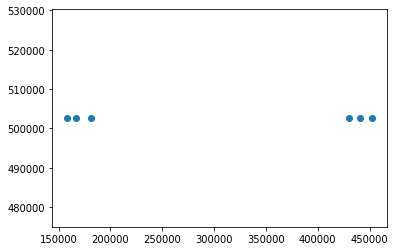

In [336]:
plt.scatter(points[:,0], points[:,1], color)

# Build out to First 10 Companies

0001391461


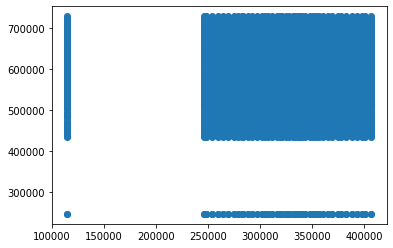

In [432]:
import matplotlib.cm as cm


plt.figure()
companies = list(link_dict.keys())[27:29]

idx = 0
for company in companies:
    
    if link_dict3[company].empty:
        print(company)
        continue
    
    sample1 = link_dict3[company]['Loc7'].values[0]
    sample2 = link_dict3[company]['Loc8'].values[0]
    
    try:
        x_points = [x[0][0] for x in sample1]
        y_points = [x[0][0] for x in sample2]
        points = np.array(list(itertools.product(x_points, y_points)))
        plt.scatter(points[:,0], points[:,1])
    except:
        print(company)
        continue
plt.show()

In [433]:
companies = list(link_dict.keys())[27:29]
companies

['0000004977', '0001391461']

In [442]:
link_dict3['0000004977']['Link'].values[0]

'https://www.sec.gov/Archives/edgar/data/4977/000000497721000047/afl-20201231.htm'

In [435]:
x_points

[114316,
 245736,
 247593,
 247975,
 253500,
 259002,
 264175,
 269233,
 274441,
 278663,
 281976,
 282917,
 287953,
 292246,
 296530,
 301746,
 304215,
 307837,
 310912,
 316022,
 318751,
 321221,
 324260,
 327586,
 331226,
 333189,
 335910,
 338018,
 339944,
 343387,
 347369,
 350549,
 353007,
 355957,
 359802,
 364992,
 369265,
 374432,
 377692,
 382552,
 387773,
 393268,
 397266,
 400941,
 406712]

In [347]:
link_dict3[company]['Link']

Series([], Name: Link, dtype: object)

In [359]:
[x for x in link_dict.keys() if link_dict[x].empty]

['0001391461',
 '0001409741',
 '0001181249',
 '0001124074',
 '0001576340',
 '0000031225',
 '0001319183',
 '0001438893',
 '0000806085',
 '0001323206',
 '0000798738',
 '0000833203']

In [364]:
link_dict[company].empty

True

# Try Another Thing

In [ ]:
start = time.time()
link_dict4 = {}

for key in list(link_dict.keys()):

    loc7list = []
    loc8list = []
    
    sample = link_dict[key].copy()
    sample = sample[sample['reportDate'].values > '1996-01-01']
    for i in range(len(sample)):
        sample_link = sample.iloc[i,:]['Link']
        response = requests.get(sample_link, headers=heads).text
        soup = BeautifulSoup(response, 'lxml')
        cleaned_soup = soup.text
        locs7 = re.finditer(r"ITEM\s7(|\.)\sManagement", cleaned_soup, re.IGNORECASE)
        locs8 = re.finditer(r"ITEM\s8(|A)(|\.)\s(Consolidated|Financial)", cleaned_soup, re.IGNORECASE)

        loc7list.append([[x.span(), x.group()] for x in locs7])
        loc8list.append([[x.span(), x.group()] for x in locs8])
    
    sample['Loc7'] = loc7list
    sample['Loc8'] = loc8list
    
    link_dict4[key] = sample.copy()

end = time.time()

In [421]:
link_dict[list(link_dict.keys())[150]]['Link'].values

array(['https://www.sec.gov/Archives/edgar/data/1051470/000105147021000031/cci-20201231.htm',
       'https://www.sec.gov/Archives/edgar/data/1051470/000105147020000077/cci10k123119q4.htm',
       'https://www.sec.gov/Archives/edgar/data/1051470/000105147019000046/cci10-k123118.htm',
       'https://www.sec.gov/Archives/edgar/data/1051470/000105147018000082/cci10-k123117.htm',
       'https://www.sec.gov/Archives/edgar/data/1051470/000105147017000059/cci10-k123116.htm',
       'https://www.sec.gov/Archives/edgar/data/1051470/000105147016000158/cci10-k123115.htm',
       'https://www.sec.gov/Archives/edgar/data/1051470/000105147015000034/cci10-k123114.htm',
       'https://www.sec.gov/Archives/edgar/data/1051470/000105147014000008/cci10-k123113.htm',
       'https://www.sec.gov/Archives/edgar/data/1051470/000105147013000007/cci10-k123112.htm',
       'https://www.sec.gov/Archives/edgar/data/1051470/000105147012000007/cci10-k123111.htm',
       'https://www.sec.gov/Archives/edgar/data/10

In [413]:
sample_link = 'https://www.sec.gov/Archives/edgar/data/6201/000000620121000014/aal-20201231.htm'
response = requests.get(sample_link, headers=heads).text

In [416]:
print(response)

IOPub data rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_data_rate_limit`.

Current values:
NotebookApp.iopub_data_rate_limit=1000000.0 (bytes/sec)
NotebookApp.rate_limit_window=3.0 (secs)



In [446]:
soup = BeautifulSoup(response, 'lxml')

In [463]:
tables = soup.findAll('table')

In [470]:
str(tables[6])

'<table cellpadding="0" cellspacing="0" style="font-family:Times New Roman;font-size:10pt;margin-left:auto;margin-right:auto;width:100%;border-collapse:collapse;text-align:left;"><tr><td colspan="1"></td></tr><tr><td style="width:100%;"></td></tr><tr><td style="vertical-align:bottom;border-bottom:1px solid #000000;padding-left:2px;padding-top:2px;padding-bottom:2px;padding-right:2px;border-top:1px solid #000000;"><div style="overflow:hidden;height:5px;font-size:10pt;"><font style="font-family:inherit;font-size:10pt;">\xa0</font></div></td></tr></table>'

In [444]:
filing = ''
for f in soup.select('font'):
    if f.text is not None and t.text != "Table of Contents":
        filing+=(f.text)+" \n"
print(filing.split('Item 1B')[0].split('Item 1A')[-1])

In [449]:
file = requests.get('https://www.sec.gov/Archives/edgar/data/101830/000010183019000022/sprintcorp201810-k.htm')                                                                      
soup = BeautifulSoup(file.content, 'html.parser')                                                                                                                                 
risk_factors_header = soup.find_all("font", text="Risk Factors")[1]                                                                                                                  
staff_comments_header = soup.find_all("font", text="Unresolved Staff Comments ")[0]                                                                                                  

In [450]:
risk_factors_header

<font style="font-family:inherit;font-size:10pt;font-style:italic;font-weight:bold;">Risk Factors</font>

In [475]:
TenKtext = soup.text

In [502]:
# Set up the regex pattern
matches = re.compile(r'item\s7[\.\s]|'
                     'item\s(8A|8)[\.\s]|'
                     'management\'s\sdiscussion\sand\sanalysis\sof\s(consolidated\sfinancial|financial)\scondition|'
                     '((consolidated\sfinancial|financial)\sstatements\sand\ssupplementary\sdata)', re.IGNORECASE)

matches_array = pd.DataFrame([(match.group(), match.start()) for match in matches.finditer(TenKtext)])
matches_array

,0,1
0,Management's Discussion and Analysis of Financ...,3834
1,Financial Statements and Supplementary Data,3988
2,Item 7.,9744
3,Management's Discussion and Analysis of Financ...,9752
4,Item 7.,14128
5,Management's Discussion and Analysis of Financ...,14136
6,Item 7.,15058
7,Management's Discussion and Analysis of Financ...,15066
8,Item 7.,146186
9,Management's Discussion and Analysis of Financ...,146194


In [503]:
# Set columns in the dataframe
matches_array.columns = ['SearchTerm', 'Start']

# Get the number of rows in the dataframe
Rows = matches_array['SearchTerm'].count()

In [517]:
# Create a new column in 'matches_array' called 'Selection' and add adjacent 
# 'SearchTerm' (i and i+1 rows) text concatenated
count = 0 # Counter to help with row location and iteration

while count < (Rows-1): # Can only iterate to the second last row
    matches_array.at[count,'Selection'] = (matches_array.iloc[count,0] + matches_array.iloc[count+1,0]).lower() # Convert to lower case
    count += 1

In [518]:
matches_array

,SearchTerm,Start,Selection
0,Management's Discussion and Analysis of Financ...,3834,management's discussion and analysis of financ...
1,Financial Statements and Supplementary Data,3988,financial statements and supplementary dataite...
2,Item 7.,9744,item 7.management's discussion and analysis of...
3,Management's Discussion and Analysis of Financ...,9752,management's discussion and analysis of financ...
4,Item 7.,14128,item 7.management's discussion and analysis of...
5,Management's Discussion and Analysis of Financ...,14136,management's discussion and analysis of financ...
6,Item 7.,15058,item 7.management's discussion and analysis of...
7,Management's Discussion and Analysis of Financ...,15066,management's discussion and analysis of financ...
8,Item 7.,146186,item 7.management's discussion and analysis of...
9,Management's Discussion and Analysis of Financ...,146194,management's discussion and analysis of financ...


In [539]:
# Set up 'Item 7/8 Search Pattern' regex patterns
matches_item7 = re.compile(r'(item\s7\.management\'s\s[a-z]*)', re.IGNORECASE)
matches_item8 = re.compile(r'(item\s(8A|8)\.(consolidated\sfinancial|financial)\s[a-z]*)', re.IGNORECASE)

# Lists to store the locations of Item 7/8 Search Pattern matches
Start_Loc = []
End_Loc = []

# Find and store the locations of Item 7/8 Search Pattern matches
count = 0 # Set up counter

while count < (Rows-1): # Can only iterate to the second last row

    # Match Item 7 Search Pattern
    if re.match(matches_item7, matches_array.at[count,'Selection']):
        # Column 1 = 'Start' columnn in 'matches_array'
        Start_Loc.append(matches_array.iloc[count,1]) # Store in list => Item 7 will be the starting location (column '1' = 'Start' column)

    # Match Item 8 Search Pattern
    if re.match(matches_item8, matches_array.at[count,'Selection']):
        End_Loc.append(matches_array.iloc[count,1])

    count += 1

In [540]:
# Extract section of text and store in 'TenKItem7'
TenKItem7 = TenKtext[Start_Loc[1]:End_Loc[1]]

# Clean newly extracted text
TenKItem7 = TenKItem7.strip() # Remove starting/ending white spaces
TenKItem7 = TenKItem7.replace('\n', ' ') # Replace \n (new line) with space
TenKItem7 = TenKItem7.replace('\r', '') # Replace \r (carriage returns-if you're on windows) with space
TenKItem7 = TenKItem7.replace(' ', ' ') # Replace " " (a special character for space in HTML) with space
TenKItem7 = TenKItem7.replace(' ', ' ') # Replace " " (a special character for space in HTML) with space
while '  ' in TenKItem7:
    TenKItem7 = TenKItem7.replace('  ', ' ') # Remove extra spaces

# Print first 500 characters of newly extracted text
print(TenKItem7[:500])

Item 7. Management's Discussion and Analysis of Financial Condition and Results of Operations" for more information.)WholesaleWe have focused our wholesale business on enabling our diverse network of customers to successfully grow their business by providing them with an array of network, product and device solutions. This allows our customers to customize this full suite of value-added solutions to meet the growing demands of their businesses. As part of these growing demands, 2Table of Content


In [526]:
Start_Loc

[9744, 14128, 15058, 146186, 149971]

In [527]:
End_Loc

[146295,
 146970,
 147685,
 149863,
 153401,
 153859,
 164581,
 186813,
 191291,
 212476,
 218745,
 264395,
 272761,
 281453,
 294774]

In [528]:
matches_array

,SearchTerm,Start,Selection
0,Management's Discussion and Analysis of Financ...,3834,management's discussion and analysis of financ...
1,Financial Statements and Supplementary Data,3988,financial statements and supplementary dataite...
2,Item 7.,9744,item 7.management's discussion and analysis of...
3,Management's Discussion and Analysis of Financ...,9752,management's discussion and analysis of financ...
4,Item 7.,14128,item 7.management's discussion and analysis of...
5,Management's Discussion and Analysis of Financ...,14136,management's discussion and analysis of financ...
6,Item 7.,15058,item 7.management's discussion and analysis of...
7,Management's Discussion and Analysis of Financ...,15066,management's discussion and analysis of financ...
8,Item 7.,146186,item 7.management's discussion and analysis of...
9,Management's Discussion and Analysis of Financ...,146194,management's discussion and analysis of financ...


In [532]:
Start_Loc

[9744, 14128, 15058, 146186, 149971]

In [538]:
idx = 4
TenKtext[Start_Loc[idx]-100:Start_Loc[idx]+10000]

'Financial Statements and Supplementary Data" of this Annual Report on Form 10-K. 30Table of ContentsItem 7.Management\'s Discussion and Analysis of Financial Condition and Results of Operations OVERVIEWBusiness OverviewSprint is a communications company offering a comprehensive range of wireless and wireline communications products and services that are designed to meet the needs of individual consumers, businesses, government subscribers, and resellers. Unless the context otherwise requires, references to "Sprint," "we," "us," "our" and the "Company" mean Sprint Corporation and its consolidated subsidiaries for all periods presented, and references to "Sprint Communications" are to Sprint Communications, Inc. and its consolidated subsidiaries. Wireless segment earnings represented almost all of our total consolidated segment earnings for the year ended March\xa031, 2019. Within the Wireless segment, postpaid wireless service revenue represents the most significant contributor to earn

In [547]:
from edgar import Company, TXTML

company = Company("Oracle Corp", "0001341439")
doc = company.get_10Ks()
text = TXTML.parse_full_10K(doc)

AttributeError: 'list' object has no attribute 'getchildren'

In [542]:
!pip install edgar

     |████████████████████████████████| 51kB 468kB/s eta 0:00:01
  Created wheel for python-levenshtein: filename=python_Levenshtein-0.12.2-cp37-cp37m-macosx_10_9_x86_64.whl size=80548 sha256=39d1f39829ebbc34746bee54d997d4ea23e763673a10ff5b76bbbc078acdf228
  Stored in directory: /Users/lucaskrenn/Library/Caches/pip/wheels/b3/26/73/4b48503bac73f01cf18e52cd250947049a7f339e940c5df8fc
Successfully built python-levenshtein
